## Dataset Setup

In [2]:
import pathlib, os, sys, operator, re, datetime
from functools import reduce
import numpy as np
import tensorflow as tf
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
import tensorflow_datasets as tfds
from tiny_imagenet import TinyImagenetDataset

# Enable or disable GPU
# To fully disable it, we need to hide all GPU devices from Tensorflow
# Make sure GPU is disabled for this inference part of the lab
ENABLE_GPU = False
# tf.debugging.set_log_device_placement(True)

if not ENABLE_GPU:
    tf.config.set_visible_devices([], 'GPU')

# Print Python and TF version, and where we are running
print(f'Running on Python Version: {sys.version}')
print(f'Using Tensorflow Version: {tf. __version__}')
if not tf.config.experimental.list_physical_devices("GPU"):
    print('Running on CPU')
else:
    print(f'Using GPU at: {tf.test.gpu_device_name()} (of {len(tf.config.experimental.list_physical_devices("GPU"))} available)')

Running on Python Version: 3.6.9 (default, Mar 10 2023, 16:46:00) 
[GCC 8.4.0]
Using Tensorflow Version: 2.6.2
Running on CPU


In [3]:
# Original Source: https://github.com/ksachdeva/tiny-imagenet-tfds
# Class Version Source: https://github.com/Mluckydwyer/tiny-imagenet-tfds
# Setup our dataset
# ---------------------------------------------------------

tiny_imagenet_builder = TinyImagenetDataset()

# this call (download_and_prepare) will trigger the download of the dataset
# and preparation (conversion to tfrecords)
#
# This will be done only once and on next usage tfds will
# use the cached version on your host.
tiny_imagenet_builder.download_and_prepare(download_dir="~/tensorflow-datasets/downloads")

# class_names = tiny_imagenet_builder.info.features['label'].names
ds = tiny_imagenet_builder.as_dataset()
ds_train, ds_val = ds["train"], ds["validation"]
assert(isinstance(ds_train, tf.data.Dataset))
assert(isinstance(ds_val, tf.data.Dataset))

# Training Dataset
ds_train = ds_train.shuffle(1024).prefetch(tf.data.AUTOTUNE)

# Validation Dataset
ds_val = ds_val.shuffle(1024).prefetch(tf.data.AUTOTUNE)

# Dataset metadata
ds_info = tiny_imagenet_builder.info

## Working with the Dataset

In [4]:
# We need to read the "human readable" labels so we can translate with the numeric values
# Read the labels file (words.txt)
with open(os.path.abspath('wnids.txt'), 'r') as f:
    wnids = [x.strip() for x in f]

# Map wnids to integer labels
wnid_to_label = {wnid: i for i, wnid in enumerate(wnids)}
label_to_wnid = {v: k for k, v in wnid_to_label.items()}

# Use words.txt to get names for each class
with open(os.path.abspath('words.txt'), 'r') as f:
    wnid_to_words = dict(line.split('\t') for line in f)
    for wnid, words in wnid_to_words.items():
        wnid_to_words[wnid] = [w.strip() for w in words.split(',')]
        
class_names = [str(wnid_to_words[wnid]) for wnid in wnids]

In [6]:
# Helper function to get the label name
def img_class(img_data, idx=None):
    image, label, id, label_name = img_data["image"], img_data["label"], img_data["id"], img_data["metadata"]['label_name']
    # Handle batches of images correctly
    if idx != None:
        image, label, id, label_name = img_data["image"][idx], img_data["label"][idx], img_data["id"][idx], img_data["metadata"]['label_name'][idx]
    
    return f"{label_name} (class index: {label} - id: {id})"


# Helper function to show basic info about an image
def img_info(img, idx=None, display=True, title_apend=""):
    image = img['image']

    # Print the clas
    class_str = img_class(img, idx)
    print(f"Label: {class_str}")
    
    # Display the image
    if display:
        plt.figure()
        plt.title(title_apend + class_str)
        # Handle batches correctly
        if image.shape.ndims > 3:
            plt.imshow(image.numpy().reshape(64, 64, 3))
        else:
            plt.imshow(image.numpy())

--- Train & Validation dataset info ---
Train: <PrefetchDataset shapes: {id: (), image: (64, 64, 3), label: (), metadata: {label_name: ()}}, types: {id: tf.string, image: tf.uint8, label: tf.int64, metadata: {label_name: tf.string}}>
Validation: <PrefetchDataset shapes: {id: (), image: (64, 64, 3), label: (), metadata: {label_name: ()}}, types: {id: tf.string, image: tf.uint8, label: tf.int64, metadata: {label_name: tf.string}}>

--- Show an example image ---
Label: b'sunglasses, dark glasses, shades' (class index: 112 - id: b'n04356056')

 Show some other examples


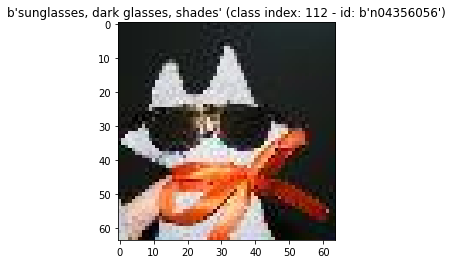

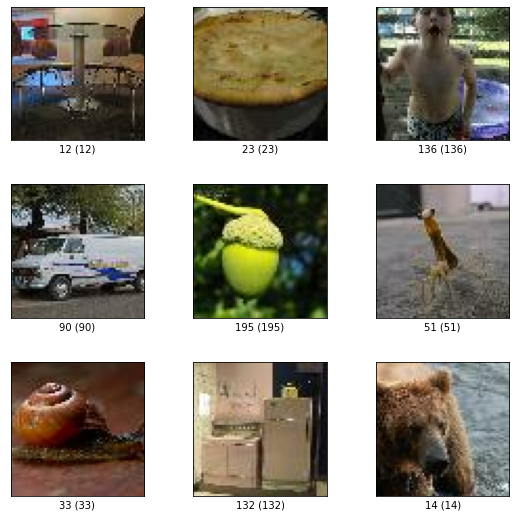

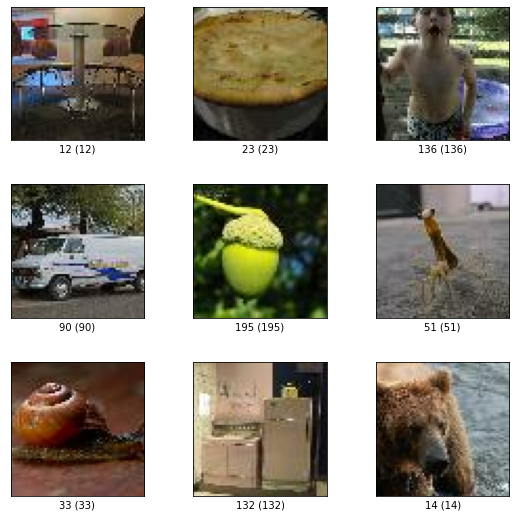

In [7]:
# Print the dataset types and info
print("--- Train & Validation dataset info ---")
print(f"Train: {ds_train}")
print(f"Validation: {ds_val}")
# print(f"Dataset Info: {ds_info}") # Uncomment to print Dataset info

print("\n--- Show an example image ---")
for example in ds_val.take(1):
    img_info(example)

print("\n Show some other examples")
tfds.show_examples(ds_val, ds_info, rows=3, cols=3)


--- Image 0 ---
Data Type: <dtype: 'uint8'>
Dimensions: (64, 64, 3)
Memory: 12288 bytes / 12.00 KB / 0.01 MB


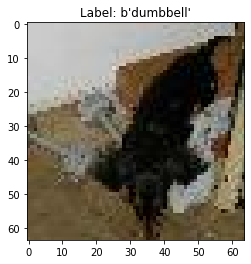


--- Image 1 ---
Data Type: <dtype: 'uint8'>
Dimensions: (64, 64, 3)
Memory: 12288 bytes / 12.00 KB / 0.01 MB


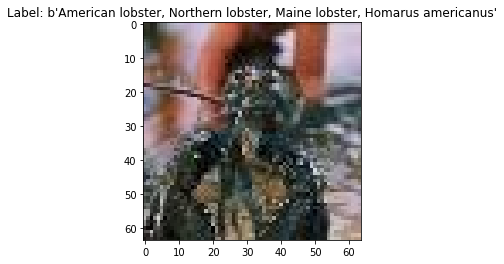


--- Image 2 ---
Data Type: <dtype: 'uint8'>
Dimensions: (64, 64, 3)
Memory: 12288 bytes / 12.00 KB / 0.01 MB


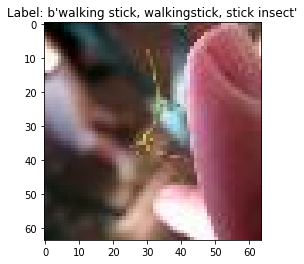

In [74]:
# TODO: Print and visualize three inputs from the validation set
#     : Print the stroage data type
#     : Print and note the dimensions of each image
#     : Print the memory required to store each image

# Sample Images
sample_imgs = []
for index, img_data in enumerate(ds_val.take(3)):
    sample_imgs.append(img_data)
    image, label, id, label_name = img_data["image"], img_data["label"], img_data["id"], img_data["metadata"]['label_name']

    print(f'\n--- Image {index} ---')
    # TODO: Your Code Here 
    # Print storage data type
    print(f"Data Type: {image.dtype}")
    
    # Print dimensions of each image
    print(f"Dimensions: {image.shape}")
    
    # Calculate memory required to store each image
    memory_bytes = tf.reduce_prod(image.shape) * image.dtype.size
    memory_kb = memory_bytes / 1024
    memory_mb = memory_kb / 1024
    print(f"Memory: {memory_bytes} bytes / {memory_kb:.2f} KB / {memory_mb:.2f} MB")
    
    # Visualize the image
    plt.figure()
    plt.imshow(image)
    plt.title(f"Label: {label_name}")
    plt.show() 

In [75]:
# TODO: Export each of the three inputs to a binary file which will be used to load the images into C++ later
# NOTE: First flatten the array (ex: 4D --> 1D). So 64*64*3 = 12288 element 1D array

# Make a directory for our image data
img_dir = os.path.abspath('img_data')
pathlib.Path(img_dir).mkdir(exist_ok=True)

# Create a metadata file
metadata_file = open(os.path.join(img_dir, f'metadata.txt'), 'w')
metadata_file.write(f'Number\t\tDims\t\tClass Data\n')

# Export each image
for index, img_data in enumerate(sample_imgs):    
    img_file_path = os.path.join(img_dir, f'image_{index}.bin')
    
    # TODO: Your Code Here
    # Flatten the image
    flattened_image = tf.reshape(img_data["image"], [-1])
    flattened_array = flattened_image.numpy()

    # Save the flattened array as a binary file
    with open(img_file_path, 'wb') as img_file:
        img_file.write(flattened_array)
  
    img_file.close()

    # Write the image metadata for reference later
    class_str = img_class(img_data)
    metadata_file.write(f'{index}\t\t{img_data["image"].shape}\t\t{class_str}\n')
metadata_file.close()

## Model Setup

In [76]:
# TODO: Load the model
# Now we will load the H5 model! Please make sure the h5 model file is present in the below directory.
# You can download this from the Canvas Page and place it in the same directory as this notebook.

# model_path = os.path.abspath(""/home/dwyer/482/dev/CNN_TinyImageNet_2.h5)" # Uncomment this to use a non-relative path
model_path = os.path.abspath("CNN_TinyImageNet_2.h5")

# TODO: Your Code Here
model = tf.keras.models.load_model(model_path)

# TODO: Print a summary of the model
# NOTE: https://www.tensorflow.org/versions/r2.6/api_docs/python/tf/keras/Model

# TODO: Your Code Here
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)        3

# Running Infrence

Label: [b'guinea pig, Cavia cobaya'] (class index: [17] - id: [b'n02364673'])
Best Guess [class index]: ['lampshade', 'lamp shade'] [61]
Best Guess Confidence (percent / 1.0): [1.]
Top 15 Guesses (class index): ['[ [61]', '[ [173]', '[ [0]', '[ [1]', '[ [2]', '[ [3]', '[ [4]', '[ [5]', '[ [6]', '[ [7]', '[ [8]', '[ [9]', '[ [10]', '[ [11]', '[ [12]']
Top 15 Guesses Confidence (percent / 1.0): [[1.000000e+00 7.881222e-09 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]]


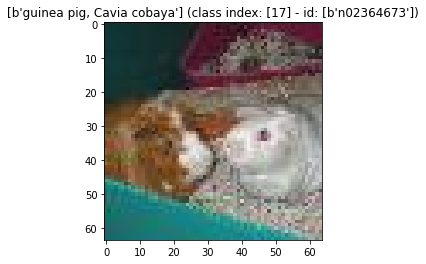

In [77]:
# Running infrence on our model
# We can run an infrence of our model by doing the following (we are doing batches of 1 here)
for example in ds_train.batch(1).take(1):
    img_info(example)
    
    # Make a prediction
    pred = model.predict(example["image"])
    # print(f'Raw 200 Class Weighted Prediction:\n{pred}') # Uncomment to see the raw prediction
    
    # What is out best guess?
    best_guess = tf.math.argmax(pred, axis=1).numpy() # Our output is 200 weighted value, we want the most likely
    print(f'Best Guess [class index]: {class_names[best_guess[0]]} [{best_guess[0]}]')
    print(f'Best Guess Confidence (percent / 1.0): {pred[0][best_guess]}')

    # What are our top 15 guesses?
    top_15 = tf.math.top_k(pred, k=15)
    print(f'Top 15 Guesses (class index): {[f"{class_names[idx][0]} [{idx}]" for idx in top_15.indices[0]]}')
    print(f'Top 15 Guesses Confidence (percent / 1.0): {top_15.values}')

Label: b'dumbbell' (class index: 154 - id: b'n03255030')
Label: b'American lobster, Northern lobster, Maine lobster, Homarus americanus' (class index: 151 - id: b'n01983481')
Label: b'walking stick, walkingstick, stick insect' (class index: 181 - id: b'n02231487')
--- Image 0 ---
Best Guess [class index]: ['viaduct'] [168]
Best Guess Confidence (percent / 1.0): 0.9955911636352539
Actual Class: b'dumbbell'
--- Image 1 ---
Best Guess [class index]: ['comic book'] [173]
Best Guess Confidence (percent / 1.0): 0.9999998807907104
Actual Class: b'American lobster, Northern lobster, Maine lobster, Homarus americanus'
--- Image 2 ---
Best Guess [class index]: ['iPod'] [91]
Best Guess Confidence (percent / 1.0): 0.9999951124191284
Actual Class: b'walking stick, walkingstick, stick insect'


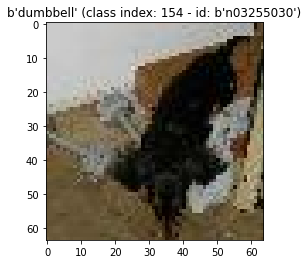

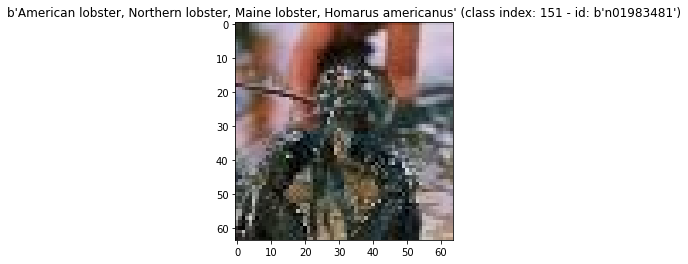

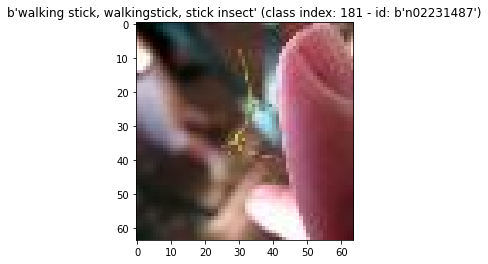

In [78]:
# TODO: Run infrence for our previous 3 sample images
# Run inference and print results for each sample image

# Resize and preprocess images
input_shape = model.input_shape[1:3]  # Assuming the model expects (height, width, channels)
for img_data in sample_imgs:
    image = img_data["image"]
    #actual_class = img_data["metadata"]["label_name"]
    img_info(img_data)
    image = tf.image.resize(image, input_shape)
    image = tf.expand_dims(image, axis=0)  # Adding a batch dimension
    img_data["image"] = image
    
for index, img_data in enumerate(sample_imgs):
    image = img_data["image"]
    actual_class = img_data["metadata"]["label_name"]

    # Make a prediction
    pred = model.predict(image)
    best_guess = tf.math.argmax(pred, axis=1).numpy()[0]
    best_guess_confidence = pred[0][best_guess]
    
    # Print results
    print(f"--- Image {index} ---")
    print(f"Best Guess [class index]: {class_names[best_guess]} [{best_guess}]")
    print(f"Best Guess Confidence (percent / 1.0): {best_guess_confidence}")
    print(f"Actual Class: {actual_class}")


# TODO: Your Code Here

In [114]:
# TODO: Calculate the Top-1, Top-5, and Top-10 Accuracy of the validation dataset
total = acc_top1 = acc_top5 = acc_top10 = 0
for img_data in ds_val:
    image = img_data["image"]
    idx = img_data["id"]
    actual_class = img_data["metadata"]["label_name"]
    actual_class_idx = actual_class.numpy()[0]
    #print(actual_class_idx)
    #print(idx)
    # Preprocess the image
    image = tf.image.resize(image, input_shape)
    image = tf.expand_dims(image, axis=0)
    
    # Make a prediction
    pred = model.predict(image)
    top_5_guesses = tf.math.top_k(pred, k=5)
    t5_idx = top_5_guesses.indices.numpy()[0]
    #print(top_5_guesses.indices.numpy()[0])

    top_10 = tf.math.top_k(pred, k=10)
    t10_idx = top_10.indices.numpy()[0]
    #print(top_10.indices.numpy()[0])
    # Calculate accuracies
    best_guess = tf.math.argmax(pred, axis=1).numpy()[0]
    #print(best_guess)
    
   

    if best_guess == actual_class_idx:
        acc_top1 += 1
    
    if actual_class_idx in t5_idx:
        acc_top5 += 1
    
    if actual_class_idx in t10_idx:
        acc_top10 += 1
    
    total += 1
    print(f"Total Images: {total}")

# Calculate percentages
acc_top1_percent = (acc_top1 / total) * 100
acc_top5_percent = (acc_top5 / total) * 100
acc_top10_percent = (acc_top10 / total) * 100

#print(f"Total Images: {total}")
print(f"Top-1 Accuracy: {acc_top1_percent:.2f}%")
print(f"Top-5 Accuracy: {acc_top5_percent:.2f}%")
print(f"Top-10 Accuracy: {acc_top10_percent:.2f}%")

# TODO: Your Code Here

Total Images: 1
Total Images: 2
Total Images: 3
Total Images: 4
Total Images: 5
Total Images: 6
Total Images: 7
Total Images: 8
Total Images: 9
Total Images: 10
Total Images: 11
Total Images: 12
Total Images: 13
Total Images: 14
Total Images: 15
Total Images: 16
Total Images: 17
Total Images: 18
Total Images: 19
Total Images: 20
Total Images: 21
Total Images: 22
Total Images: 23
Total Images: 24
Total Images: 25
Total Images: 26
Total Images: 27
Total Images: 28
Total Images: 29
Total Images: 30
Total Images: 31
Total Images: 32
Total Images: 33
Total Images: 34
Total Images: 35
Total Images: 36
Total Images: 37
Total Images: 38
Total Images: 39
Total Images: 40
Total Images: 41
Total Images: 42
Total Images: 43
Total Images: 44
Total Images: 45
Total Images: 46
Total Images: 47
Total Images: 48
Total Images: 49
Total Images: 50
Total Images: 51
Total Images: 52
Total Images: 53
Total Images: 54
Total Images: 55
Total Images: 56
Total Images: 57
Total Images: 58
Total Images: 59
Total 

In [99]:
# TODO: Print all of the possible classes of the dataset
print(class_names)
# TODO: Your Code Here

["['Egyptian cat']", "['reel']", "['volleyball']", "['rocking chair', 'rocker']", "['lemon']", "['bullfrog', 'Rana catesbeiana']", "['basketball']", "['cliff', 'drop', 'drop-off']", "['espresso']", '[\'plunger\', "plumber\'s helper"]', "['parking meter']", "['German shepherd', 'German shepherd dog', 'German police dog', 'alsatian']", "['dining table', 'board']", "['monarch', 'monarch butterfly', 'milkweed butterfly', 'Danaus plexippus']", "['brown bear', 'bruin', 'Ursus arctos']", "['school bus']", "['pizza', 'pizza pie']", "['guinea pig', 'Cavia cobaya']", "['umbrella']", "['organ', 'pipe organ']", "['oboe', 'hautboy', 'hautbois']", "['maypole']", "['goldfish', 'Carassius auratus']", "['potpie']", "['hourglass']", "['seashore', 'coast', 'seacoast', 'sea-coast']", "['computer keyboard', 'keypad']", "['Arabian camel', 'dromedary', 'Camelus dromedarius']", "['ice cream', 'icecream']", "['nail']", "['space heater']", "['cardigan']", "['baboon']", "['snail']", "['coral reef']", "['albatros

## Model Exploration

In [ ]:
# TODO: Visualize the model in Netron and include an image here.
tf.keras.utils.plot_model(model, "model.png", show_shapes=True, show_dtype=True, expand_nested=True) # Uncomment this to generate an image visualization

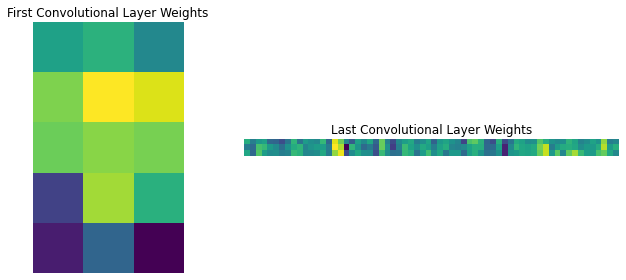

In [117]:
# We can view the layer weights as well. Here we are pretending they are images
# TODO: Visualize the 2 convolutional layers filter sets (weights) (one at the beginning and one at the end)

# TODO: Your Code Here
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the pre-trained model
#model_path = 'CNN_TinyImageNet_2.h5'  # Update with the actual path to your model file
#model = tf.keras.models.load_model(model_path)

# Get the weights of the first and last convolutional layers
conv1_weights = model.layers[0].get_weights()[0]
last_conv_weights = model.layers[7].get_weights()[0]  # Replace with the correct layer index

# Normalize and reshape weights for visualization
normalized_conv1_weights = (conv1_weights - np.min(conv1_weights)) / (np.max(conv1_weights) - np.min(conv1_weights))
normalized_last_conv_weights = (last_conv_weights - np.min(last_conv_weights)) / (np.max(last_conv_weights) - np.min(last_conv_weights))

# Plot the weights as images using Matplotlib
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(normalized_conv1_weights[0, :, :, 0], cmap='viridis')
plt.title('First Convolutional Layer Weights')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(normalized_last_conv_weights[0, :, :, 0], cmap='viridis')
plt.title('Last Convolutional Layer Weights')
plt.axis('off')

plt.tight_layout()
plt.show()


---
 Image 0 ---
Conv. Layer: conv2d


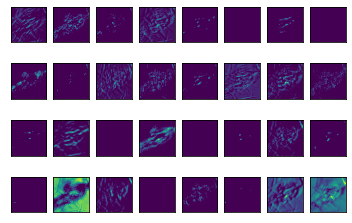

Conv. Layer: conv2d_1


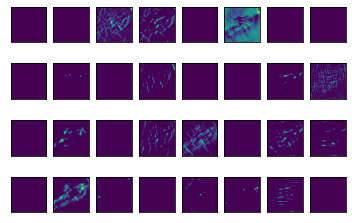

Conv. Layer: conv2d_2


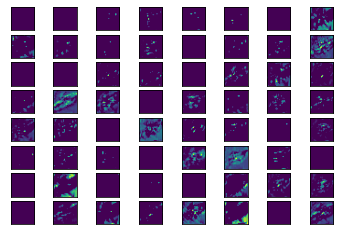

Conv. Layer: conv2d_3


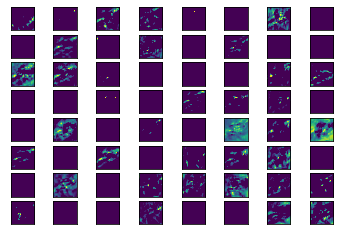

Conv. Layer: conv2d_4


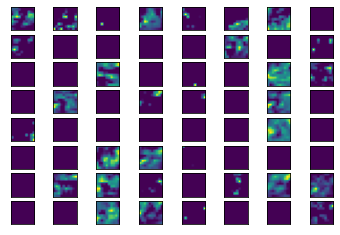

Conv. Layer: conv2d_5


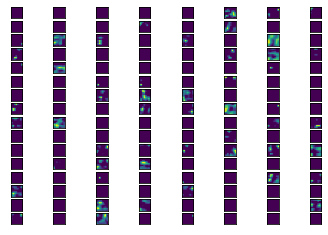

---
 Image 1 ---
Conv. Layer: conv2d


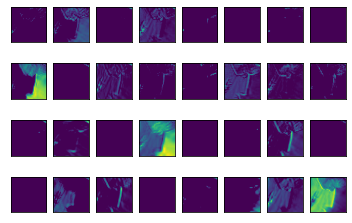

Conv. Layer: conv2d_1


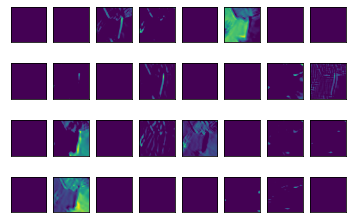

Conv. Layer: conv2d_2


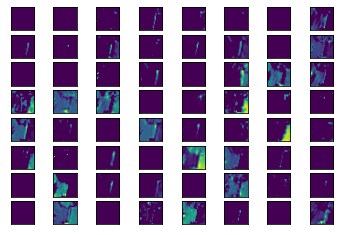

Conv. Layer: conv2d_3


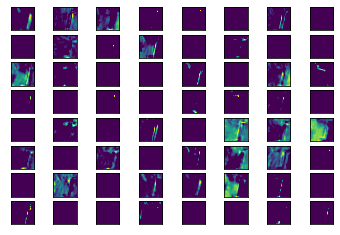

Conv. Layer: conv2d_4


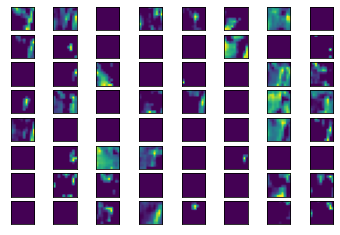

Conv. Layer: conv2d_5


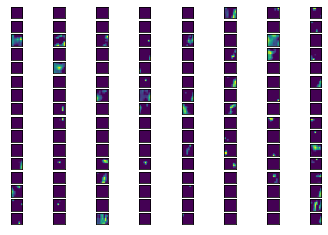

---
 Image 2 ---
Conv. Layer: conv2d


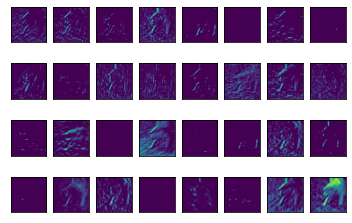

Conv. Layer: conv2d_1


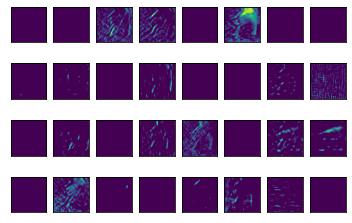

Conv. Layer: conv2d_2


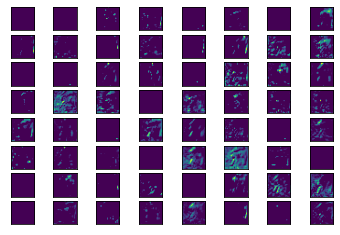

Conv. Layer: conv2d_3


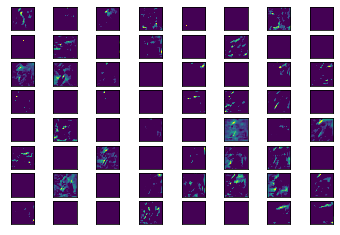

Conv. Layer: conv2d_4


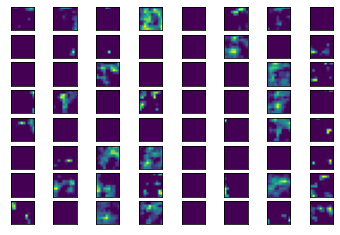

Conv. Layer: conv2d_5


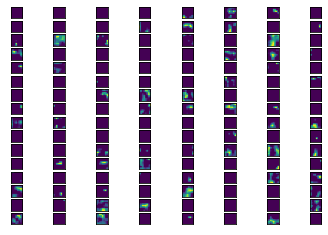

In [ ]:
# We can again view the layer outputs as well. Here we are pretending they are images
# TODO: Visualize the 2 convolutional layers outputs (intermediate feature maps) (one at the beginning and one at the end)

# TODO: Your Code Here

In [ ]:
# TODO: Export the filters/weights se we can use them later
# Make a directory for our image data
model_dir = os.path.abspath('model_data')
pathlib.Path(model_dir).mkdir(exist_ok=True)


# Export each image
conv_index = dense_index = 1 # layer index starts from one
for layer_idx, layer in enumerate(model.layers):
    if re.match("conv", layer.name):
        weight_file_name = os.path.join(model_dir, f'conv{conv_index}_weights.bin')
        bias_file_name = os.path.join(model_dir, f'conv{conv_index}_weights.bin')
        conv_index += 1
    elif re.match("dense", layer.name):
        weight_file_name = os.path.join(model_dir, f'dense{conv_index}_weights.bin')
        bias_file_name = os.path.join(model_dir, f'dense{conv_index}_weights.bin')
        dense_index += 1
    else:
        continue
        
        # TODO: Your Code Here
            
print(f"All the convolution and dense (fully connected) weights and biases successfully exported to input folders in {model_dir} directory")

All the convolution and dense (fully connected) weights and biases successfully exported to input folders in /home/mmanish/work/TA/487/lab1_testing/model_data directory


/home/mmanish/work/TA/487/lab1_testing/lab1/lib64/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
# TODO: Export the intermediate layer outputs for each of the input for all of the layers
img_dir = os.path.abspath('img_data')
pathlib.Path(img_dir).mkdir(exist_ok=True)

for img_idx, img in enumerate(sample_imgs):
    file_dir = os.path.join(img_dir, f'test_input_{img_idx}')
    pathlib.Path(file_dir).mkdir(exist_ok=True)
    
    for layer_idx, layer in enumerate(model.layers):
        aux_model = tf.keras.Model(inputs=model.inputs, outputs=[layer.output])
        
        # Store the intermediate output
        
        # TODO: Your Code Here
        
print(f"All the corresponding intermediate layer outputs successfully exported to each input folder in the {img_dir} directory")

All the corresponding intermediate layer outputs successfully exported to each input folder in the /home/mmanish/work/TA/487/lab1_testing/img_data directory


## Tensorboard

In [ ]:
# Setup for profiling
tf.profiler.experimental.ProfilerOptions(
    host_tracer_level=1, python_tracer_level=0, device_tracer_level=1
)

log_dir = os.path.abspath(os.path.join('log_data', datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))
pathlib.Path(log_dir).mkdir(exist_ok=True, parents=True)

In [ ]:
# TODO: Sample Profiling - Inference for a single image:

# Perform the inference profiling:
for example in ds_train.batch(1).take(1):
    # Starts Profile logging
    tf.profiler.experimental.start(os.path.join(log_dir, f'single-{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'))

    # Actual inference
    # TODO: Your Code Here
 
    # Stops Profile logging
    tf.profiler.experimental.stop()

# Load the TensorBoard notebook extension.
%load_ext tensorboard

# Launch TensorBoard and navigate to the Profile tab to view performance profile. 
# *** Please note just execute this command ones in a session and 
# then logs for subsequent runs would be auto detected in tensorboard- url: http://localhost:6006/
%tensorboard --logdir=log_dir

# You could view the tensorboard in the browser url: http://localhost:6006/

In [ ]:
# TODO: Sample Profiling - Online Inference:

# Vary this from 10, 100, 1000 to simulate multiple online inference
loop_index = [10, 100, 1000]

for idx in loop_index:
    # Starts Profile logging
    tf.profiler.experimental.start(os.path.join(log_dir, f'online-infrence-{idx}-{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'))

    # Actual online inference
    # TODO: Your Code Here

    # Stops Profile logging
    tf.profiler.experimental.stop()

# You could view the tensorboard in the browser url: http://localhost:6006/ and then in the profile tab navigate to the latest run.

In [ ]:
# TODO: Sample Profiling - Batch Inference:

# We would only perform batch inference for a subset of validation set i.e. 1000 images 
# using different batch sizes of 20, 40, 100, 200 

# Decides the size of the batch. Try: 20, 40, 100, 200
batch_size = [20, 40, 100, 200]

for batch in batch_size:
    # Starts Profile logging
    tf.profiler.experimental.start(os.path.join(log_dir, f'batch-{batch}-{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'))

    # Actual Batch inference
    # TODO: Your Code Here        

    # Stops Profile logging
    tf.profiler.experimental.stop()

# You could view the tensorboard in the browser url: http://localhost:6006/ and then in the profile tab navigate to the latest run.


## Training

In [ ]:
# Setup for model training
from tensorflow.keras import Model, datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, ZeroPadding2D,Convolution2D, Activation, Dropout 

train_dir = os.path.abspath(os.path.join('train_data', datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))
pathlib.Path(train_dir).mkdir(exist_ok=True, parents=True)

# Using early stopping to monitor validation accuracy
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1,
    ),
    tf.keras.callbacks.TensorBoard(log_dir=train_dir, histogram_freq=1)
]

In [ ]:
# Basic CNN model
train_model = Sequential()

# conv1
train_model.add(Conv2D(32, (5, 5), input_shape=(64, 64, 3), activation='relu'))
train_model.add(Conv2D(32, (5,5),activation='relu'))
train_model.add(MaxPooling2D(pool_size=(2, 2)))
train_model.add(Conv2D(64, (3,3), activation='relu'))
train_model.add(Conv2D(64, (3,3), activation='relu'))
train_model.add(MaxPooling2D(pool_size=(2, 2)))
train_model.add(Conv2D(64, (3,3), activation='relu'))
train_model.add(Conv2D(128, (3,3), activation='relu'))
train_model.add(MaxPooling2D(pool_size=(2, 2)))
train_model.add(Flatten())

# fc1
train_model.add(Dense(256, activation='relu'))

# fc2
train_model.add(Dense(200, activation='softmax'))

train_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
train_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)        3

In [ ]:
# TODO: Attempt to train your own model with different batch sizes


def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255., label

def to_categorical(image, label):
    label = tf.one_hot(tf.cast(label, tf.int32), 200)
    return tf.cast(image, tf.float32), tf.cast(label, tf.int64)

ds_re = tiny_imagenet_builder.as_dataset(as_supervised=True)
ds_retrain, ds_reval = ds_re["train"], ds_re["validation"]

ds_retrain = ds_retrain.cache().shuffle(1024)
ds_reval = ds_reval.cache().shuffle(1024)

ds_retrain = ds_retrain.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_reval = ds_reval.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

ds_retrain = ds_retrain.map(to_categorical, num_parallel_calls=tf.data.AUTOTUNE)
ds_reval = ds_reval.map(to_categorical, num_parallel_calls=tf.data.AUTOTUNE)

epoch_size = 20


for batch_size in [32, 64, 128]:
    # Setup our batched datasets
    # TODO: Your Code Here
    
    # Run training
    # TODO: Your Code Here
 
    # Save the cnn model
    train_model.save(os.path.join(log_dir, f'CNN_TinyImageNet_train_batch{batch_size}.h5'))

    # TODO: Get the top-1 and top-5 of your newly trained model
    # TODO: Your Code Here

<class 'tensorflow.python.data.ops.dataset_ops.ParallelMapDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
Epoch 1/20
3125/3125 [==============================] - 479s 153ms/step - loss: 5.2993 - accuracy: 0.0045 - val_loss: 5.2984 - val_accuracy: 0.0050
Epoch 2/20
3125/3125 [==============================] - 475s 152ms/step - loss: 5.2994 - accuracy: 0.0043 - val_loss: 5.2984 - val_accuracy: 0.0050
Epoch 3/20
3125/3125 [==============================] - 474s 152ms/step - loss: 5.2994 - accuracy: 0.0044 - val_loss: 5.2984 - val_accuracy: 0.0050
Epoch 4/20
3125/3125 [==============================] - 478s 153ms/step - loss: 5.2994 - accuracy: 0.0044 - val_loss: 5.2985 - val_accuracy: 0.0050
Epoch 5/20
3125/3125 [==============================] - 474s 152ms/step - loss: 5.2994 - accuracy: 0.0044 - val_loss: 5.2985 - val_accuracy: 0.0050
Epoch 6/20
3125/3125 [==============================] - 471s 1

In [ ]:
# TODO: Train your model with 3 different numbers of epochs
batch_size = 32

# Setup your datasets
# TODO: Your Code Here

for epoch_size in [3, 10, 100]:
    # Run training
    # TODO: Your Code Here

    # Save the cnn model
    train_model.save(os.path.join(log_dir, f'CNN_TinyImageNet_train_batch{batch_size}.h5'))

    # TODO: Get the top-1 and top-5 of your newly trained model
    # TODO: Your Code Here

NameError: name 'train_model' is not defined

## Above and Beyond

In [ ]:
# Benchmark our dataset to make sure loading our data isn't a bottleneck ... and because we can
# (This can be skipped since it can take a bit and is't all that important)

# tfds.benchmark(ds_train.batch(32), batch_size=32, num_iter=2**20)